# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [3]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

## The Euro problem

In Chapter xx (https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/07_euro.ipynb) I presented a problem from David MacKay's book, [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/p0.html):

> A statistical statement appeared in The Guardian on
Friday January 4, 2002:
>
> >"When spun on edge 250 times, a Belgian one-euro coin came
up heads 140 times and tails 110. ‘It looks very suspicious
to me’, said Barry Blight, a statistics lecturer at the London
School of Economics. ‘If the coin were unbiased the chance of
getting a result as extreme as that would be less than 7%’."
>
> But [asks MacKay] do these data give evidence that the coin is biased rather than fair?

To answer this question, we made these modeling decisions:

* If you spin a coin on edge, there is some probability, $x$, that it will land heads up.

* The value of $x$ varies from one coin to the next, depending on how the coin is balanced and other factors.

We started with a uniform prior distribution for $x$, then updated it with the given data, 140 heads and 110 tails.  Then we used the posterior distribution to compute the MAP, posterior mean, and a credible interval.

But we never really answered MacKay's question.  Now we will.  But first, let's review the solution from Chapter xx.

## Binomial distribution

Suppose I tell you that a coin is "fair", that is, the probability of heads is 50%.  If you spin it twice, there are four outcomes: `HH`, `HT`, `TH`, and `TT`.

All four outcomes have the same probability, 25%.  If we add up the total number of heads, it is either 0, 1, or 2.  The probability of 0 and 2 is 25%, and the probability of 1 is 50%.

More generally, suppose the probability of heads is `p` and we spin the coin `n` times.  What is the probability that we get a total of `k` heads?

The answer is given by the binomial distribution:

$P(k; n, p) = \binom{n}{k} p^k (1-p)^{n-k}$

where $\binom{n}{k}$ is the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), usually pronounced "n choose k".

We can compute this expression ourselves, but we can also use the SciPy function `binom.pmf`:

In [53]:
xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)
uniform.normalize()

101

If we put this result in a Series, the result is the distribution of `k` for the given values of `n` and `p`.

In [54]:
from scipy.stats import binom

k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

In [55]:
posterior = uniform * likelihood
posterior.normalize()

0.0039446175693263405

The following function computes the binomial distribution for given values of `n` and `p`:

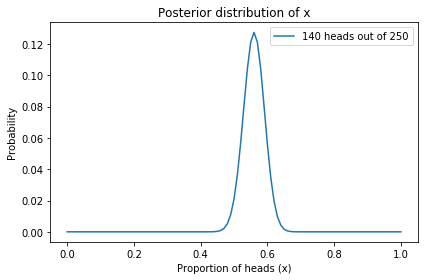

In [56]:
posterior.plot(label='140 heads out of 250')

decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title='Posterior distribution of x')

## Evidence

Finally, let's get back to MacKay's question: do these data give evidence that the coin is biased rather than fair?

In Chapter 5, we said that data are considered evidence in favor of a hypothesis, $A$, if the data are more likely under $A$ than under the alternative, $B$; that is

$P(D|A) > P(D|B)$

Furthermore, we can quantify the strength of the evidence by computing the ratio of these likelihoods, which is known as the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) and often denoted $K$:

$ K = \frac{P(D|A)}{P(D|B)}$

So, for the Euro problem, let's consider two hypotheses, `fair` and `biased`, and compute the likelihood of the data under each hypothesis.

If the coin is fair, the probability of heads is 50%, and we can compute the probability of the data (140 heads out of 250 spins) using the binomial distribution:

In [57]:
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_fair

0.008357181724917673

That's the probability of the data, given that the coin is fair.

But if the coin is biased, what's the probability of the data?  Well, that depends on what "biased" means.

If we know ahead of time that "biased" means the probability of heads is 56%, we can use the binomial distribution again:

In [58]:
like_biased = binom.pmf(k, n, p=0.56)
like_biased

0.05077815959517949

Now we can compute the likelihood ratio:

In [40]:
K = like_biased / like_fair
K

6.075990838368387

The data are about 6 times more likely if the coin is biased, by this definition, than if it is fair.

But we used the data to define the hypothesis, which seems like cheating.  To be fair, we should define "biased" before we see the data.

## Uniformly distributed bias

Suppose "biased" means that the probability of heads is anything except 50%, and all other values are equally likely.

We can represent that definition by making a uniform distribution and removing 50%.

In [41]:
biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()

100

To compute the probability of the data under this hypothesis, we compute the probability of the data for each value of $x$.

In [42]:
xs = biased_uniform.qs
likelihood = binom.pmf(k, n, xs)

Then multiply by the prior probabilities and add up the products:

In [43]:
like_uniform = np.sum(biased_uniform * likelihood)
like_uniform

0.0039004919277704267

So that's the probability of the data under the "biased uniform" hypothesis.

Now we can compute the likelihood ratio of the data under the `fair` and `biased uniform` hypotheses:

In [45]:
K = like_fair / like_uniform
K

2.1425968518013954

The data are about two times more likely if the coin is fair that if it is biased, by definition of "biased".

To get a sense of how strong that evidence is, we can apply Bayes's rule.
For example, if the prior probability is 50% that the coin is biased, the prior odds are 1, so the posterior odds are about 2.1 to 1 and the posterior probability is about 68%.

In [46]:
prior_odds = 1
posterior_odds = prior_odds * K
posterior_odds

2.1425968518013954

In [47]:
def prob(o):
    return o / (o+1)

In [49]:
posterior_probability = prob(posterior_odds)
posterior_probability

0.6817918278551125

Evidence that "moves the needle" from 50% to 68% is not very strong.

**Exercise:** Suppose "biased" doesn't mean every value of $x$ is equally likely.  Maybe values near 50% are more likely and values near the extremes are less likely.  

We could use a triangle-shaped distribution to represent this alternative definition of "biased":

In [59]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

In [60]:
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle /= biased_triangle.sum()

Compute the total probability of the data under this definition of "biased" and use a Bayes table to compare it with the fair hypothesis.

Is the data evidence that the coin is biased?

In [61]:
# Solution

like_triangle = np.sum(biased_triangle * likelihood)
like_triangle

0.006981325464857327

In [63]:
# Solution

K = like_fair / like_triangle
K

1.1970766535647344

In [64]:
# Solution

# For this definition of "biased", the data are 
# very slightly in favor of the fair hypothesis.

## Bayesian hypothesis testing

What we've done so far in this chapter is sometimes called "Bayesian hypothesis testing" to contrast it with [statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing), also know as null hypothesis significance testing (NHST).

In statistical hypothesis testing, we compute a p-value, which is hard to define concisely, and use it to determine whether the results are "statistically significant", which is also  hard to define consisely.

The Bayesian alternative is to report the Bayes factor, $K$, which summarizes the strength of the evidence in favor of one hypothesis or the other.

Some people think it is better to report $K$ than a posterior probability because $K$ does not depend on a prior probability.

But as we saw in this example, $K$ often depends on a precise definition of the hypotheses, which can be just as controversial as a prior probability.

In my opinion, Bayesian hypothesis testing is better than NHST because it measures the strength of the evidence on a continuum, rather that trying to make a binary determination.

But it doesn't solve what I think is the fundamental problem, which is that hypothesis testing is not asking the question we really care about.

To see why, suppose you test the coin and decide that it is biased after all.  Now what?  That is, what can you do with this answer?  In my opinion, not much.

In contrast, there are two kind of questions I think are more useful (and therefore more meaningful):

* Prediction: Based on what we know about the coin, what should we expect to happen in the future?

* Decision-making: Can we use those predictions to make better decisions?

At this point, we've seen several examples of prediction.  For example, in Chapter xx we used the posterior distribution of goal-scoring rates to predict the outcome of soccer games.  And in Chapters xx and xx we used the distribution of regression parameters to make predictions for the Space Shuttle and climate change, among other examples.

And we've seen one previous example of decision analysis: In Chapter xx we used the distribution of prices to choose an optimal bid on *The Price is Right*.

So let's finish this chapter with another example of Bayesian decision analysis, the Bayesian Bandit strategy.

## Bayesian Bandit

If you have ever been to a casino, you have probably seen a slot machines, which is sometimes called a "one-armed bandits" because it has a handle like an arm and the ability to take money like a bandit.

The Bayesian Bandit strategy is named after one-armed bandits because it solves a problem based a simplified version of a slot machine.

Suppose that each time you play a slot machine, there is a fixed probability that you win.  And suppose that different machines give you different probabilities of winning, but you don't know what the probabilities are.

Initially, you have the same prior belief about each of the machines, so you have no reason to prefer one over the others.  But if you play each machine a few times, you can use the results to estimate the probabilities.  And you can use the estimated probabilities to decide which machine to play next.

At a high level, that's the Bayesian bandit strategy.  Now let's see the details.

## Prior beliefs

If we know nothing about the probability of wining, we can start with a uniform prior.

In [7]:
xs = np.linspace(0, 1, 101)
prior = Pmf(1, index=xs)
prior.normalize()

101

Now I'll make four copies of the prior to represent our beliefs about the four machines.

In [8]:
beliefs = [prior.copy() for i in range(4)]

This function displays four distributions in a grid.

In [29]:
options = dict(xticklabels='invisible', yticklabels='invisible')

def plot(beliefs, **options):
    for i, pmf in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        pmf.plot(label='Machine %s' % i)
        decorate(yticklabels=[])
        
        if i in [0, 2]:
            decorate(ylabel='PDF')
        
        if i in [2, 3]:
            decorate(xlabel='Probability of winning')
        
    plt.tight_layout()

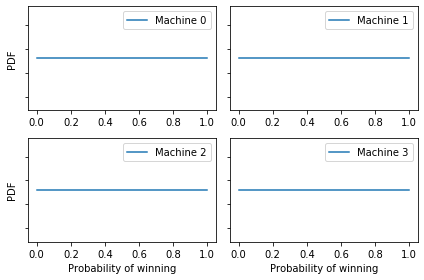

In [30]:
plot(beliefs)

## The update

Each time we play a machine, we can use the outcome to update our beliefs.  The following function does the update.

In [33]:
def update(pmf, data):
    """Update the probability of winning
    
    pmf: Pmf of win probabilities
    data: string, either 'W' or 'L'
    """
    xs = pmf.qs
    if data == 'W':
        likelihood = xs
    else:
        likelihood = 1 - xs
        
    pmf *= likelihood
    pmf.normalize()

`pmf` is a `Pmf` that represents the prior distribution of `x`, which is the probability of winning.

`data` is a string, either `W` if the outcome is a win or `L` if the outcome is a loss.

The likelihood of the data is either `xs` or `1-xs`, depending on the outcome.

This function updates the prior distribution in place.

Suppose we choose a machine, play 10 times, and win once.  We can compute the posterior distribution of `x`, based on this outcome, like this:

In [34]:
bandit = prior.copy()

for outcome in 'WLLLLLLLLL':
    update(bandit, outcome)

Here's what the posterior looks like.

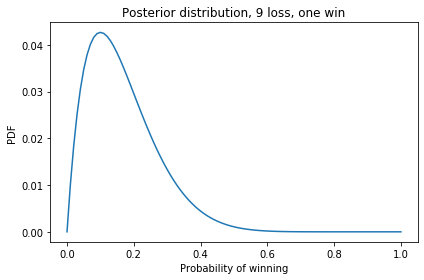

In [35]:
bandit.plot()
decorate(xlabel='Probability of winning',
         ylabel='PDF',
         title='Posterior distribution, 9 loss, one win')

## Multiple bandits

Now suppose we four machines with these probabilities:

In [36]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

Remember that as a player, we don't know these probabilities.

I'll use the following function to simulate playing one machine once and returns `W` or `L`.

In [39]:
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def play(i):
    """Play machine i.
    
    i: index of the machine to play
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

`play` takes the index of the machine we want to play, and returns `'W'` or `'L'` to indicate whether we won or lost.

`counter` is a `Counter`, which is a kind of dictionary we'll use to keep track of how many time each machine is played.

Here's a test that plays each machine 10 times.

In [41]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

Each time through the inner loop, we play one machine and update our beliefs.

Here's what our posterior beliefs look like.

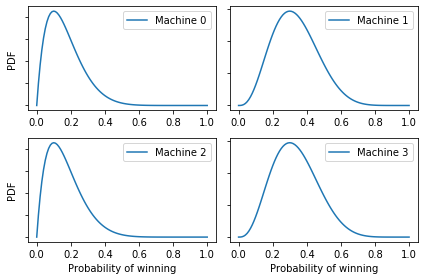

In [42]:
plot(beliefs)

Here are the actual probabilities, posterior means, 90% credible intervals.

In [85]:
def summarize_beliefs(beliefs):
    """
    """
    columns = ['Actual P(win)', 'Posterior mean', 'Credible interval']
    df = pd.DataFrame(columns=columns)
    for i, b in enumerate(beliefs):
        df.loc[i] = actual_probs[i], b.mean(), b.credible_interval(0.9)
    return df

In [86]:
table = summarize_beliefs(beliefs)
table

,Actual P(win),Posterior mean,Credible interval
0,0.1,0.200120,"[0.04, 0.43]"
1,0.2,0.095567,"[0.0, 0.28]"
2,0.3,0.400000,"[0.3, 0.5]"
3,0.4,0.434783,"[0.27, 0.6]"


We expect the credible intervals to contain the actual probabilities most of the time.

## Explore and Exploit

Based on these posterior distributions, which machine do you think we should play next?  One option would be to choose the machine with the highest posterior mean.  

That would not be a bad idea, but it has a drawback: since we have only played each machine a few times, the posterior distributions are wide and overlapping, which means we are not sure which machine is the best; if we focus on one machine too soon, we might choose the wrong machine and play it more than we should.

To avoid that problem, we could go to the other extreme and play all machines equally until we are confident we have identified the best machine, and then play it exclusively.

That's not a bad idea either, but it has a drawback, too: while we are gathering data, we are not making good use of it; until we're sure which machine is the best, we are playing the others more than we should.

The Bayesian Bandits strategy avoids both drawbacks by gathering and using data at the same time.  In other words, it balances exploration and exploitation.

The kernel of the idea is called [Thompson sampling](): when we choose a machine, we choose at random so that the probability of choosing each machine is proportional to the probability that it is the best.

Given the posterior distributions, we can compute the "probability of superiority" for each machine.

Here's one way to do it.  We can draw a sample of 1000 values from each posterior distribution, like this:

In [87]:
samples = np.array([b.choice(1000) for b in beliefs])
samples.shape

(4, 1000)

The result has 4 rows and 1000 columns.  We can use `argmax` to find the index of the largest value in each column:

In [88]:
indices = np.argmax(samples, axis=0)
indices.shape

(1000,)

The `Pmf` of these indices is the fraction of times each machine yielded the highest values.

In [89]:
pmf = Pmf.from_seq(indices)
pmf

,probs
0,0.037
1,0.002
2,0.395
3,0.566


These fractions approximate the probability of superiority for each machine.  So we could choose the next machine by choosing a value from this `Pmf`.

In [90]:
pmf.choice()

2

But that's a lot of work to choose a single value, and it's not really necessary, because there's a shortcut.

If we draw a single random value from each posterior distribution and select the machine that yields the highest value, it turns out that we'll select each machine in proportion to its probability of superiority.

That's what the following function does.

In [91]:
def choose(beliefs):
    """Use Thompson sampling to choose a machine.
    
    Draws a single sample from each distribution.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [b.choice(1) for b in beliefs]
    return np.argmax(ps)

This function chooses one value from the posterior distribution of each machine and then uses `argmax` to find the index of the machine that yielded the highest value.

Here's an example.

In [92]:
choose(beliefs)

2

## The Strategy

Putting it all together, the following function chooses a machine, plays once, and updates `beliefs`:

In [93]:
def choose_play_update(beliefs, verbose=False):
    """Chose a machine, play it, and update beliefs.
    
    beliefs: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    update(beliefs[machine], outcome)
    
    if verbose:
        print(i, outcome, beliefs[machine].mean())

To test it out, let's start again with a fresh set of beliefs and an empty `Counter`.

In [94]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

If we run the bandit algorithm 100 times, we can see how `beliefs` gets updated:

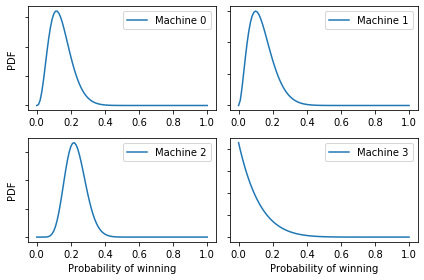

In [95]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior mean and credible interval:

In [96]:
summarize_beliefs(beliefs)

,Actual P(win),Posterior mean,Credible interval
0,0.1,0.142856,"[0.05, 0.26]"
1,0.2,0.136365,"[0.04, 0.27]"
2,0.3,0.229167,"[0.14, 0.33]"
3,0.4,0.095567,"[0.0, 0.28]"


The credible intervals usually contain the actual probabilities of winning.

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

More importantly, let's see how many times each machine got played.  If things go according to plan, the machines with higher probabilities should get played more often.

In [111]:
def summarize_counter(counter):
    """
    """
    columns = ['Actual P(win)', 'Times played']
    df = pd.DataFrame(columns=columns)
    for i, count in counter.items():
        df.loc[i] = actual_probs[i], count
    return df

In [112]:
summarize_counter(counter)

,Actual P(win),Times played
0,0.1,26.0
2,0.3,46.0
3,0.4,8.0
1,0.2,20.0


## Summary

In this notebook we finally answered the original version of the Euro problem, considering whether the data support the hypothesis that the coin is fair or biased.  We found that the answer depends on how we define "biased".  And we summarized the results using a Bayes factor, which quantifies the strength of the evidence.

But it wasn't very satisfying...

The algorithm ... is an example of a general strategy called [Bayesian decision theory](https://wiki.lesswrong.com/wiki/Bayesian_decision_theory), which is the idea of using a posterior distribution as part of a decision-making process, usually by choosing an action that minimizes the costs we expect on average (or maximizes a benefit).

In my opinion, this strategy is the biggest advantage of Bayesian methods over classical statistics.  When we represent knowledge in the form of probability distributions, Bayes's theorem tells us how to change our beliefs as we get more data, and Bayesian decisions theory tells us how to make that knowledge actionable.

## Exercises

**Exercise:** In preparation for an alien invasion, the Earth Defense League has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, `x`.

Based on previous tests, the distribution of `x` in the population of designs is roughly uniform between 10% and 40%.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, a Defense League general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad; that is, does it increase or decrease your estimate of `x` for the Alien Blaster 9000?

Plot the prior and posterior distributions, and use the following function to compute the prior and posterior means.

In [39]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [40]:
# Solution

xs = np.linspace(0.1, 0.4)
prior = pd.Series(1, index=xs)
prior /= prior.sum()

In [41]:
# Solution

likelihood = xs**2 + (1-xs)**2

In [42]:
# Solution

posterior = prior * likelihood
posterior /= posterior.sum()

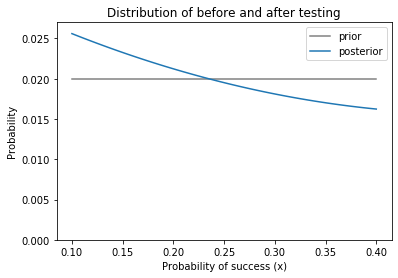

In [43]:
# Solution

prior.plot(color='gray', label='prior')
posterior.plot(label='posterior')

plt.xlabel('Probability of success (x)')
plt.ylabel('Probability')
plt.ylim(0, 0.027)
plt.title('Distribution of before and after testing')
plt.legend();

In [44]:
# Solution

pmf_mean(prior), pmf_mean(posterior)

(0.25, 0.2378145906339599)

In [45]:
# With this prior, being "consistent" is more likely
# to mean "consistently bad".